In [64]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import math
import mat73
from datetime import datetime
import calendar
import allantools as al
import re
from scipy.stats import poisson
from scipy.stats import norm
import gmpy2 as gm
import mpmath as mp

In [65]:
#------------------------ CHANGE THIS----------------
tInt = 2.77 #s
#----------------------------------------

In [114]:
mp.mp.dps = 50
fe3 = mp.mpf('642121496772645.10')
fe2 = mp.mpf('688358979309308.22')
R_Godun = mp.mpf('0.93282940453096496') #mp.mpf('0.93282940453096465')
R_Lange = mp.mpf('0.932829404530965376')

In [67]:
B = mp.mpf(31.275/(1e-9*0.59930*9.2740100657e-24/6.626e-34)) # in mu T
e2Zee = 52.14*B**2*1e-3
e3Zee = -2.082*B**2*1e-3
e2BBR = -517e-18*fe2
e3BBR = -73.6e-18*fe3
e2Quad = 0.0 #0.049409
e3Quad = 0.0 #-0.049409/92.1
e2Shift = (e2Zee+e2BBR+e2Quad)
e3Shift = (e3Zee+e3BBR+e3Quad)

In [68]:
def lineFit(x,m,b):
    return m*x+b
def Gauss(x, A, sig, mu): 
    y = (A/np.sqrt(2*np.pi*sig**2))*np.exp((-(x-mu)**2)/(2.*sig**2)) 
    return y 

def linePts(x, y):
    n = np.size(x)
    fitYs = np.zeros(n)
    param, paramcov = curve_fit(lineFit,x,y, maxfev=5000)
    print(param[0])
    for ii in range(n):
        fitYs[ii] = lineFit(x[ii], param[0], param[1])
    return fitYs

def arbTimetoEpoch(t,t0): #takes t, time elapsed in s since t0 (a date time) and returns epoch time corresponding to t
    return t + t0.timestamp()

def nowToEpoch(time): #takes matlab "now" serial date number in days from Jan 1 0000 and converts to epoch time (s from 1970)
    dec = math.modf(time)[0]
    ing = int(math.modf(time)[1])
    t = datetime.fromordinal(ing-366).timestamp() + dec*24*60*60
    return t

In [69]:
def movingAvg(data, avgPts):
    if avgPts%2 == 1:
        n = np.size(data)
        avgData = np.zeros(n)
        for ii in range(avgPts//2):
            avgData[ii] = mp.fsum(data[:ii+avgPts//2+1])/np.size(data[:ii+avgPts//2+1])
            avgData[n-1-ii] = mp.fsum(data[n-ii-1-avgPts//2:])/np.size(data[n-ii-1-avgPts//2:])
        for ii in range(avgPts//2,n-avgPts//2,1):
            avgData[ii] = mp.fsum(data[ii-avgPts//2:ii+avgPts//2+1])/np.size(data[ii-avgPts//2:ii+avgPts//2+1])
        return avgData
    else: print("avgPts must be odd")

In [70]:
def importMokuPro(filename):
    lines=[]
    with open(filename, 'r') as file:
        for line in file:
            lines.append(line)
            #print(line.strip()) 
    lines = lines[14:]
    n = len(lines)
    ts = np.zeros(n)
    f871 = np.zeros(n)
    f933 = np.zeros(n)
    for ii in range(n):
        entries = lines[ii].split(',')
        ts[ii] = float(entries[0])
        #f729[ii] = float(entries[2])
        f871[ii] = float(entries[7])
        f933[ii] = float(entries[12])

    match = re.search(r"(\d{4})(\d{2})(\d{2})_(\d{2})(\d{2})(\d{2})", filename)
    dt = tuple(map(int, match.groups()))
    #print(dt)
    ts = arbTimetoEpoch(ts, datetime(*dt))
    return ts, f871, f933

In [71]:
def mokuBreaker(data): #use this if there is a gap in the moku data
    ts, f933s, f871s, taoms, fE2aoms, fe3aom, beatSign933, beatSign871, frep = data
    for ii in range(np.size(ts)-1):
        if ts[ii+1]-ts[ii]>(1/36):
            print("Breaking Moku data at n= ",ii)
            n1=ii
    tsa = ts[:n1]
    tsb = ts[n1+1:]
    f871a = f871s[:n1]
    f871b = f871s[n1+1:]
    f933a = f933s[:n1]
    f933b = f933s[n1+1:]
    fe2aomsCopy = [arr.copy() for arr in fE2aoms]
    fe3aomCopy = np.copy(fe3aom)
    taomsCopy = np.copy(taoms)
    tsa, f933a, f871a, taoma, fe2aoma, fe3aoma = trimData(tsa, f933a, f871a, taoms, fE2aoms, fe3aom)
    dataA = tsa, f933a, f871a, taoma, fe2aoma, fe3aoma, beatSign933, beatSign871, frep
    tsb, f933b, f871b, taomb, fe2aomb, fe3aomb = trimData(tsb, f933b, f871b, taomsCopy, fe2aomsCopy, fe3aomCopy)
    dataB = tsb, f933b, f871b, taomb, fe2aomb, fe3aomb, beatSign933, beatSign871, frep
    return dataA, dataB

In [72]:
def importMatlab(filename):
    mat = mat73.loadmat(filename)
    n=int(mat['currentdatapointnr'])
    ni = 0  #-----------cut off points while servo grabs---------------
    taoms=mat['aomfrequsmatrix'][ni:n-1,0]
    #print(ts[0])

    for ii in range(np.size(taoms)):
        taoms[ii] = nowToEpoch(taoms[ii])         #times now in epoch time
    fe2aom1=mat['aomfrequsmatrix'][ni:n-1,1]
    fe2aom2=mat['aomfrequsmatrix'][ni:n-1,2]
    fe2aom3=mat['aomfrequsmatrix'][ni:n-1,3]
    fe2aoms = [fe2aom1,fe2aom2,fe2aom3]
    fe3aom=mat['aomfrequsmatrix'][ni:n-1,4]
    return taoms, fe2aoms, fe3aom

In [73]:
def trimData(ts, f933s, f871s, taoms, fe2aoms, fe3aom):
    ni=0
    if ts[0]>taoms[0]:
        print("case 1")
        for ii in range(np.size(taoms)):
            if (taoms[ii] - tInt)>ts[0]: 
                ni=ii
                #print(ni)
                break
        #print(ni)
        taoms = taoms[ni:]
        for ii in range(3):
            fe2aoms[ii] = fe2aoms[ii][ni:]
        fe3aom = fe3aom[ni:]
        #print("should be negative: ")
        print(ts[0]-taoms[0])
    else:
        print("case 2")
        # Cutting off first 30 points of aom data to give servo time to catch
        #--------------------------------------------------------
        nServo = 30
        taoms = taoms[nServo:]
        for ii in range(3):
            fe2aoms[ii] = fe2aoms[ii][nServo:]
        fe3aom = fe3aom[nServo:]
        for ii in range(np.size(ts)):
            if ts[ii]>(taoms[0]-tInt):
                ni=ii
                #print(ni)
                break
        ts = ts[ni:]
        f871s = f871s[ni:]
        f933s = f933s[ni:]
        #print("should be negative: ")
        print(ts[0]-taoms[0])
    
    if ts[-1]>taoms[-1]:
        print("case 1")
        for ii in range(np.size(ts)):
            if ts[ii]>taoms[-1]:
                nf=ii
                break
        ts = ts[:nf+1]
        f871s = f871s[:nf+1]
        f933s = f933s[:nf+1]
        #print("should be positve: ")
        print(ts[-1]-taoms[-1])
    else:
        print("case 2")
        for ii in range(np.size(taoms)):
            if taoms[ii]>ts[-1]:
                nf=ii
                break
        #print(nf)
        taoms = taoms[:nf]
        for ii in range(3):
            fe2aoms[ii] = fe2aoms[ii][:nf]
        fe3aom = fe3aom[:nf]
        #print("should be positve: ")
        print(ts[-1]-taoms[-1])
    return ts, f933s, f871s, taoms, fe2aoms, fe3aom

In [74]:
def ratioCalc(data):
    ts, f933s, f871s, taoms, fe2aoms, fe3aom, beatSign933, beatSign871, frep = data
    #Average beat note data
    n = np.size(taoms)
    f871adj = np.zeros(n)
    f933adj = np.zeros(n)
    ii = 0
    n1 = 0 
    n2 = 0
    while ii<n:
        while ts[n1] < (taoms[ii]-tInt):
            n1+=1
        while ts[n2] < taoms[ii]:
            n2 +=1
        f871adj[ii] = np.average(f871s[n1:n2])
        f933adj[ii] = np.average(f933s[n1:n2])
        ii+=1
        
    for ii in range(np.size(f871adj)):
        if f871adj[ii]==None:
            print(ii)
    #Calculate comb teeth
    fceo = mp.mpf('70e6')
    print("------Comb Teeth------")
    print((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(161.5e6)/2)/frep)
    n871 = round((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(161.5e6)/2)/frep)
    print(n871)
    print((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+100e6/2)/frep)
    n933 = round((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+100e6/2)/frep)
    print(n933)
    print("----------------------")

    #Calculate ratio
    print(f871adj[0])
    nuA = fceo - beatSign871*f871adj
    nuB = (n871/n933)*(fceo-beatSign933*f933adj)
    nuC = nuA - nuB
    f933 = fe3/2 + np.average(fe3aom)/2 + 80e6
    ratio = nuC/f933+n871/n933
    e3Quad = -np.array([(fe2aoms[0][i] + fe2aoms[1][i] + fe2aoms[2][i]) / 3 for i in range(len(fe2aoms[0]))] - fe2aoms[0])/92.1
    R1 = (2-160e6/f933-fe3aom/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-fe2aoms[0]/f933-e2Shift/f933)
    R2 = (2-160e6/f933-fe3aom/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-fe2aoms[1]/f933-e2Shift/f933)
    R3 = (2-160e6/f933-fe3aom/f933-(e3Shift+e3Quad)/f933)/(2.*ratio-240e6/f933-fe2aoms[2]/f933-e2Shift/f933)
    Rs = np.array([R1,R2,R3])
    return taoms, Rs

In [75]:
def fullRatio(dataSets, setNum):
    setAvgRatios = np.array([[mp.mpf(0) for _ in range(setNum)] for _ in range(3)], dtype=object)
    Ratio = [np.empty((0,)) for _ in range(3)]
    durations = np.zeros(setNum)
    numPts = np.zeros(setNum)
    tFulls = np.array([])
    t0s = np.zeros(setNum)
    for ii in range(setNum):
        print("-----",ii+1,"-----")
        #ts, f933s, f871s, taoms, fe2aoms, fe3aom, beatSign933, beatSign871, frep = dataSets[ii]
        taoms, Rpts = ratioCalc(dataSets[ii])
        for jj in range(3):
            Ratio[jj] = np.concatenate((Ratio[jj], Rpts[jj]))
            setAvgRatios[jj][ii] = mp.fsum(Rpts[jj])/np.size(Rpts[jj])
        #npdiscreteRatio[ii] = np.average(Rpts)
        durations[ii] = taoms[-1]-taoms[0]
        t0s[ii] = taoms[0]
        numPts[ii] = np.size(taoms)
        tFulls = np.concatenate((tFulls, taoms))
    return tFulls, Ratio, setAvgRatios, durations, t0s, numPts

In [76]:
def files2data(mokuFile, aomFile, beatSign933, beatSign871, frep):
    ts, f871s, f933s  = importMokuPro(mokuFile)
    taoms, fe2aoms, fe3aom  = importMatlab(aomFile)
    print("Trimming.....")
    ts, f933s, f871s, taoms, fe2aoms, fe3aom = trimData(ts, f933s, f871s, taoms, fe2aoms, fe3aom)
    print("Done.")
    print("Start time: ", datetime.fromtimestamp(taoms[0]))
    print("End time: ", datetime.fromtimestamp(taoms[-1]))
    return ts, f933s, f871s, taoms, fe2aoms, fe3aom, beatSign933, beatSign871, frep

First you use files2data to get data sets. Then use the plotter to make sure it looks good. Then for those sets that need it, you trim them with a file trimmer function or split them with mokuBreaker.

In [77]:
def snipData(data, Ncutf):
    ts, f933s, f871s, taoms, fe2aoms, fe3aom, beatSign933, beatSign871, frep = data
    ts = ts[:Ncutf]
    f933s = f933s[:Ncutf]
    f871s = f871s[:Ncutf]
    ts, f933s, f871s, taoms, fe2aoms, fe3aom = trimData(ts, f933s, f871s, taoms, fe2aoms, fe3aom)
    return ts, f933s, f871s, taoms, fe2aoms, fe3aom, beatSign933, beatSign871, frep

In [78]:
path = r"C:\Users\markl\Documents\Data\E2E3Ratio"

file1 = path+r"\MokuPhasemeterData_20250605_092639.csv"
file1a = path+r"\aomfrequs-20250605_1.mat"

file2 = path+r"\MokuPhasemeterData_20250606_101748.csv"
file2a = path+r"\aomfrequs-20250606_1.mat"

file3 = path+r"\MokuPhasemeterData_20250609_071029.csv"
file3a = path+r"\aomfrequs-20250609_1.mat"

file4 = path+r"\MokuPhasemeterData_20250609_113237.csv"
file4a = path+r"\aomfrequs-20250609_2.mat"

file5 = path+r"\MokuPhasemeterData_20250610_100701.csv"
file5a = path+r"\aomfrequs-20250610_2_a.mat"

file6 = path+r"\MokuPhasemeterData_20250611_085253.csv"
file6a = path+r"\aomfrequs-20250611_1.mat"

file7 = path+r"\MokuPhasemeterData_20250612_092854.csv"
file7a = path+r"\aomfrequs-20250612_1.mat"

file8 = path+r"\MokuPhasemeterData_20250613_125943.csv"
#file8a = path+r"\aomfrequs-20250613_1.mat"
file8a_2 = path+r"\aomfrequs-20250613_2.mat"

file9 = path+r"\MokuPhasemeterData_20250623_105443.csv"
file9a = path+r"\aomfrequs-20250623_1.mat"
file9a_2 = path+r"\aomfrequs-20250623_2.mat" ####has a jump in the beatnotes, questionable

file10 = path+r"\MokuPhasemeterData_20250625_131204.csv"
file10a = path+r"\aomfrequs-20250625_1.mat"

file11 = path+r"\MokuPhasemeterData_20250626_130648.csv"
file11a = path+r"\aomfrequs-20250626_1_a.mat"

file12 = path+r"\MokuPhasemeterData_20250630_123500.csv"
file12a = path+r"\aomfrequs-20250630_1_a.mat"

In [79]:
sets = []
data1 = files2data(file1, file1a, -1, 1, 19998371.28/4+245000000)
sets.append(data1)
data2 = files2data(file2, file2a, 1, -1, 19997957.612/4+245000000)
sets.append(data2)
data3 = files2data(file3, file3a, 1, -1, 19997957.612/4+245000000)
data3 = snipData(data3, 550263)
sets.append(data3)
data4 = files2data(file4, file4a,  1, -1, 19997957.612/4+245000000)
sets.append(data4)
#sets.append([file5, file5a, -1, 1, 19998419.343/4+245000000])
data6 = files2data(file6, file6a, -1, -1, 19998474.699/4+245000000)
data6a, data6b = mokuBreaker(data6)
sets.append(data6a)
sets.append(data6b)
data7 = files2data(file7, file7a, -1, -1, 19998474.699/4+245000000)
sets.append(data7)
data8 = files2data(file8, file8a_2, -1, -1, 19998474.699/4+245000000)
sets.append(data8)
data9 = files2data(file9, file9a, -1, 1, 19998322.8/4+245000000)
sets.append(data9)
data10 = files2data(file10, file10a, -1, 1, 19998322.8/4+245000000)
sets.append(data10)
data11 = files2data(file11, file11a, -1, 1, 19998322.8/4+245000000)
sets.append(data11)
data12 = files2data(file12, file12a, -1, -1, 19997754.06/4+245000000)
sets.append(data12)

Trimming.....
case 2
-2.764284133911133
case 1
0.006681203842163086
Done.
Start time:  2025-06-05 09:48:47.567001
End time:  2025-06-05 17:31:45.932997
Trimming.....
case 1
-4.5670013427734375
case 1
0.02323627471923828
Done.
Start time:  2025-06-06 10:17:52.567001
End time:  2025-06-06 19:10:27.928999
Trimming.....
case 1
-4.935997009277344
case 1
0.011974811553955078
Done.
Start time:  2025-06-09 07:10:33.935997
End time:  2025-06-09 11:20:48.944999
case 2
-2.746377944946289
case 2
2.333085536956787
Trimming.....
case 1
-3.7619993686676025
case 1
0.0037610530853271484
Done.
Start time:  2025-06-09 11:32:40.761999
End time:  2025-06-09 18:09:56.077998
Trimming.....
case 1
-3.0081918239593506
case 1
0.018532752990722656
Done.
Start time:  2025-06-11 08:52:56.384001
End time:  2025-06-11 17:53:51.820997
Breaking Moku data at n=  483981
case 2
-2.7592766284942627
case 2
0.008007049560546875
case 1
-3.848163366317749
case 1
0.018532752990722656
Trimming.....
case 1
-4.501000881195068
case

In [80]:
ts, f871s, f933s  = importMokuPro(file5)
taoms, fe2aoms, fe3aom  = importMatlab(file5a)
ts, f933s, f871s, taoms, fe2aoms, fe3aom = trimData(ts, f933s, f871s, taoms, fe2aoms, fe3aom)

case 1
-3.6851885318756104
case 1
0.010591983795166016


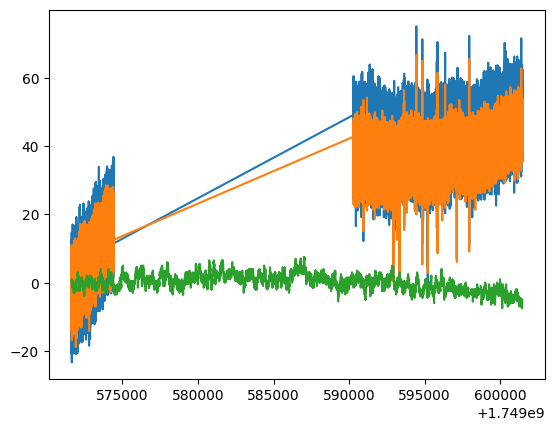

In [81]:
plt.plot(ts, f871s-f871s[0])
plt.plot(ts, f933s-f933s[0])
plt.plot(taoms, fe2aoms[0]-fe2aoms[0][0])
#plt.xlim([1.74949e9-600,1.74949e9+90000])

In [82]:
data12 = files2data(file1, file1a, -1, -1, 19997754.06/4+245000000)
#data9 = snipData(data9, 461936)

#data5a, data5b = mokuBreaker(data5)
ts, f933s, f871s, taoms, fe2aoms, fe3aom, beatSign933, beatSign871, frep = data1

Trimming.....
case 2
-2.764284133911133
case 1
0.006681203842163086
Done.
Start time:  2025-06-05 09:48:47.567001
End time:  2025-06-05 17:31:45.932997


In [83]:
np.mean(fe3aom)

np.float64(100000087.52287324)

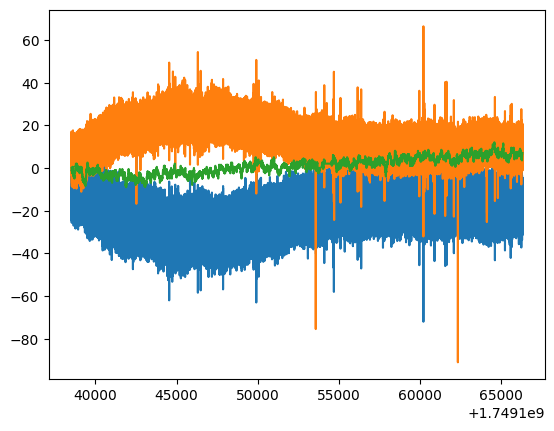

In [84]:
plt.plot(ts, f871s-f871s[0])
plt.plot(ts, f933s-f933s[0])
plt.plot(taoms, fe2aoms[0]-fe2aoms[0][0])

In [85]:
ts, f933s, f871s, taoms, fe2aoms, fe3aom, beatSign933, beatSign871, frep = data1

In [86]:
fe2aoms[0][0]

np.float64(81499963.0)

In [87]:
fe2aoms[2][0]

np.float64(81499961.0)

In [88]:
(81499963.0+81499961.0+81499961.0)/3-81499963.0

-1.3333333283662796

In [89]:
(fe2aoms[0]- np.mean(np.array(fe2aoms)))

array([-1.00861377, -1.50861377, -1.50861377, ...,  5.99138623,
        5.99138623,  5.99138623])

In [90]:
np.array([(fe2aoms[0][i] + fe2aoms[1][i] + fe2aoms[2][i]) / 3 for i in range(len(fe2aoms[0]))] - fe2aoms[0])

array([-1.33333333, -1.        , -1.16666667, ...,  1.5       ,
        1.33333333,  1.        ])

In [91]:
-(fe2aoms[0][0]- np.mean(np.array(fe2aoms[0]), axis=0))/92.1

np.float64(0.011323876476702034)

In [92]:
data1 = files2data(file1, file1a, -1, 1, 19998371.28/4+245000000)
#data6a, data6b = mokuBreaker(data6)
taoms, Rs = ratioCalc(data1)

Ravgs = np.zeros(3)
for ii in range(3):
    Ravgs[ii] = mp.fsum(Rs[ii])/np.size(Rs[ii])

Trimming.....
case 2
-2.764284133911133
case 1
0.006681203842163086
Done.
Start time:  2025-06-05 09:48:47.567001
End time:  2025-06-05 17:31:45.932997
------Comb Teeth------
1376721.0000031703712823190091028078840128444664008
1376721
1284245.0000027162517494458500027843555701371538035
1284245
----------------------
109022892.40726922


In [93]:
1e17*(mp.fsum(Rs[:,0])/3.0-R_Lange)

mpf('260.12457286181804501011838179573808414145150589479895')

In [94]:
datetime.fromtimestamp(taoms[0])

datetime.datetime(2025, 6, 5, 9, 48, 47, 567001)

In [95]:
Rs[2]

array([mpf('0.93282940453096707381265317358116337261780592069470922'),
       mpf('0.9328294045309659317123206006365499873694368224673823'),
       mpf('0.93282940453096700270523845173052625366874397538841279'),
       ...,
       mpf('0.93282940453097031092813156943342940270830042831206203'),
       mpf('0.93282940453097034989290825821464651898672516824004954'),
       mpf('0.93282940453097015275796620623497108324872895898656901')],
      dtype=object)

In [96]:
1e17*(mp.fsum(Ravgs)/np.size(Ravgs)-R_Lange)

mpf('-11.258356157708719062308470408121744687148647962607597')

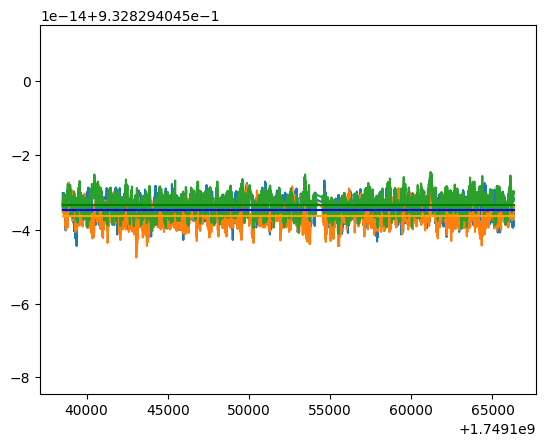

In [97]:
lim = 5e-14
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])
plt.plot(taoms,Rs[0],color="tab:blue")
plt.plot(taoms,Rs[1],color="tab:orange")
plt.plot(taoms,Rs[2],color="tab:green")
plt.plot((taoms[0],taoms[-1]),(Ravgs[0],Ravgs[0]),color="blue")
plt.plot((taoms[0],taoms[-1]),(Ravgs[1],Ravgs[1]),color="orange")
plt.plot((taoms[0],taoms[-1]),(Ravgs[2],Ravgs[2]),color="green")

In [98]:
ts, Ratio, setAvgRatios, Ts, t0s, Ns = fullRatio(sets, 12)
fullRatios = np.zeros(np.shape(Ratio)[1])
for ii in range(np.shape(Ratio)[1]):
    fullRatios[ii] = (Ratio[0][ii]+Ratio[1][ii]+Ratio[2][ii])/3

----- 1 -----
------Comb Teeth------
1376721.0000031703712823190091028078840128444664008
1376721
1284245.0000027162517494458500027843555701371538035
1284245
----------------------
109022892.40726922
----- 2 -----
------Comb Teeth------
1376721.0000192566042064482665646241962806162195465
1376721
1284246.0000177420517369196019614469998905286748055
1284246
----------------------
33349374.278771263
----- 3 -----
------Comb Teeth------
1376721.0000110324050223885768149872806060117249982
1376721
1284246.0000101007494154741729828598948951729493841
1284246
----------------------
33351474.74805515
----- 4 -----
------Comb Teeth------
1376721.0000111580976751166712542020878185764419155
1376721
1284246.0000102171543533782478505126732357793658471
1284246
----------------------
33351502.26139206
----- 5 -----
------Comb Teeth------
1376719.9999761252689779047406431190098519486330188
1376720
1284244.9999775686600746145552713214001712211894465
1284245
----------------------
105388650.54791138
----- 6

In [99]:
discRs= np.zeros(np.size(Ts))
for ii in range(np.size(Ts)):
    discRs[ii] = mp.fdiv(mp.fadd(setAvgRatios[0][ii],mp.fadd(setAvgRatios[1][ii],setAvgRatios[2][ii])),3.0)

In [116]:
ratioVal

mpf('0.9328294045309651845115144047311521804867838349497213')

In [112]:
ratioVal = (mp.fsum(Ratio[0])/np.size(Ratio[0])+mp.fsum(Ratio[1])/np.size(Ratio[1])+mp.fsum(Ratio[2])/np.size(Ratio[2]))/3
fe2*(ratioVal-R_Lange)/R_Lange

mpf('-0.14130431336490839869504620415911728908970204100740341')

In [115]:
fe2*(ratioVal-R_Godun)/R_Godun

mpf('0.16567286167027953291729615452694750612558412665479374')

In [101]:
ratioVal = mp.fsum(np.concatenate(Ratio))/np.size(Ratio)
fe2*(ratioVal-R_Lange)/R_Lange

mpf('-0.14130431336490839869504620415911729007585319513942889')

In [102]:
ratioVal = mp.fsum(discRs)/np.size(discRs)
fe2*(ratioVal-R_Lange)/R_Lange

mpf('-0.1445230006495631532330386832452154975922294006877492')

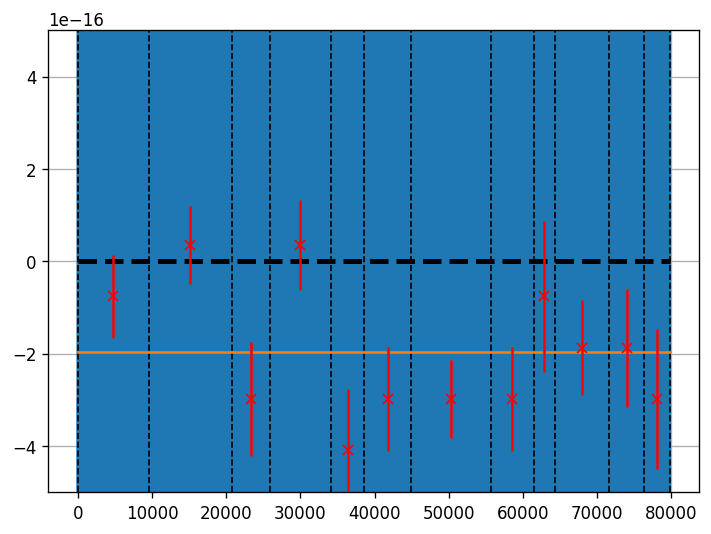

In [103]:
plt.figure(figsize=(7,5), dpi = 120)
lim = 5e-16
A = 1.5e-14
plt.ylim([-lim, lim])
plt.plot(fullRatios-R_Lange)
plt.grid()

xScatpts = np.zeros(np.size(Ns))
for ii in range(np.size(Ns)):
    xScatpts[ii] = np.sum(Ns[:ii]) + Ns[ii]/2
for ii in range(np.size(Ns)+1):
    ###plt.plot([float(Ravg)-lim, float(Ravg)+lim], [0,0], ls="--", c="bl")
    plt.plot([np.sum(Ns[:ii]),np.sum(Ns[:ii])], [-lim,+lim], lw=1, ls="--", c="black")

errors = np.zeros(np.size(discRs))
for ii in range(np.size(discRs)):
    errors[ii] = A/np.sqrt(Ts[ii])


floatRs = [float(val) for val in discRs]
plt.errorbar(xScatpts, discRs-R_Lange, yerr=errors,fmt="x", color="red", zorder=10)
plt.plot([0, np.size(fullRatios)], [ratioVal-R_Lange, ratioVal-R_Lange])
plt.plot([0, np.size(fullRatios)], [0, 0], ls="--", color="black", linewidth=3)
plt.show()

In [104]:
1e16*(discRs-R_Lange)

array([mpf('-0.75576127422915305942296981811523436900280597974775242'),
       mpf('0.35446175039600348100066184997558594349719402025224758'),
       mpf('-2.9762073234794661402702331542968749940028059797477524'),
       mpf('0.35446175039600348100066184997558594349719402025224758'),
       mpf('-4.0864303481046226806938648223876953065028059797477524'),
       mpf('-2.9762073234794661402702331542968749940028059797477524'),
       mpf('-2.9762073234794661402702331542968749940028059797477524'),
       mpf('-2.9762073234794661402702331542968749940028059797477524'),
       mpf('-0.75576127422915305942296981811523436900280597974775242'),
       mpf('-1.8659842988543095998466014862060546815028059797477524'),
       mpf('-1.8659842988543095998466014862060546815028059797477524'),
       mpf('-2.9762073234794661402702331542968749940028059797477524')],
      dtype=object)

NameError: name 'discreteFullRatios' is not defined

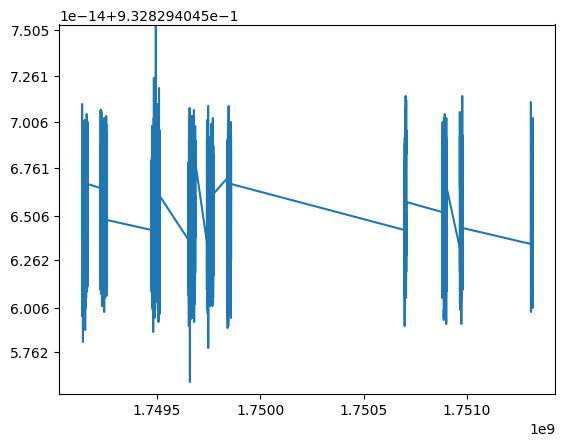

In [105]:
lim = 1e-14
plt.ylim([float(R_Lange)-lim, float(R_Lange)+lim])

plt.plot(ts,fullRatios)
plt.errorbar(t0s+Ts/2, discreteFullRatios, yerr=1.5e-14/np.sqrt(Ts),c="black", marker="x",zorder=2)
plt.plot([ts[0],ts[-1]], [R_Lange,R_Lange])
plt.plot([ts[0],ts[-1]], [ratioVal,ratioVal], color="green")

#plt.scatter(t0s+durations/2, discreteFullRatios, c="black", marker="x",zorder=2)
plt.grid()

In [106]:
floatRs = np.array([float(pt) for pt in fullRatios])
rate = 1./tInt
taus,adev,adevErr,_ = al.adev(fullRatios, rate, data_type="freq")

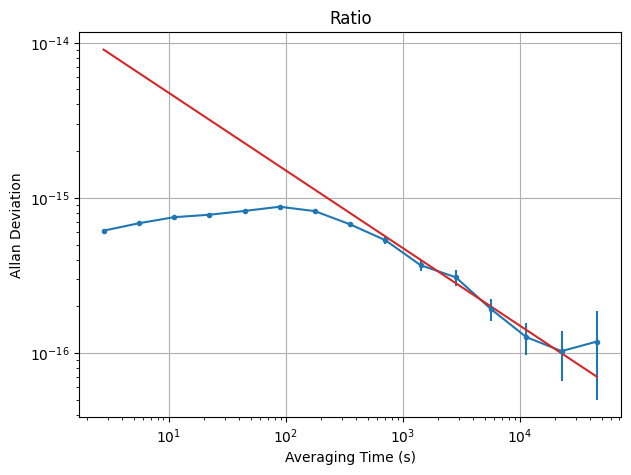

In [107]:
A = 1.5e-14

plt.figure(figsize=(7,5), dpi = 100)

plt.errorbar(taus, adev, yerr=adevErr, fmt=".", c="tab:blue")
plt.loglog(taus, adev, label="Ratio", c="tab:blue")
plt.loglog(taus, A/np.sqrt(taus), c="tab:red")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Allan Deviation")
plt.xlabel("Averaging Time (s)")
plt.title("Ratio")
#plt.ylim([3e-17, 3e-15])
plt.grid()
plt.show()

In [108]:
quadShift = -Ratio[0]+Ratio[1]
quadShiftfloat = np.array([float(pt) for pt in quadShift])
rate = 1./tInt
taus,adev,adevErr,_ = al.adev(quadShiftfloat, rate, data_type="freq")

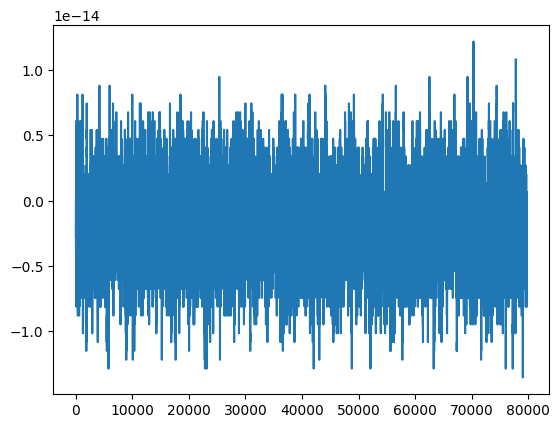

In [109]:
plt.plot(quadShift)

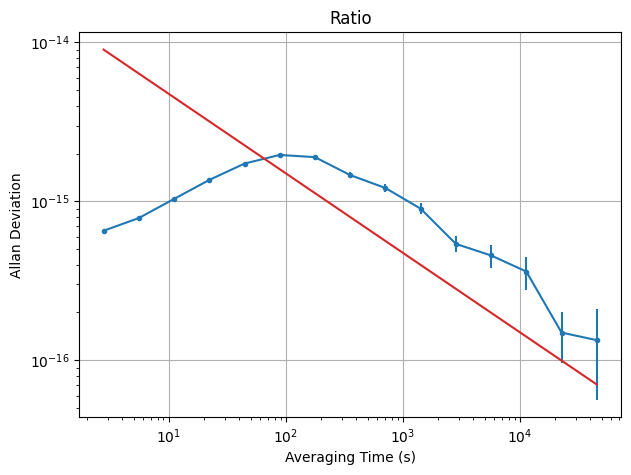

In [110]:
A = 1.5e-14

plt.figure(figsize=(7,5), dpi = 100)

plt.errorbar(taus, adev, yerr=adevErr, fmt=".", c="tab:blue")
plt.loglog(taus, adev, label="Ratio", c="tab:blue")
plt.loglog(taus, A/np.sqrt(taus), c="tab:red")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Allan Deviation")
plt.xlabel("Averaging Time (s)")
plt.title("Ratio")
#plt.ylim([3e-17, 3e-15])
plt.grid()
plt.show()